In [1]:
from lspi.basis_functions import ExactBasis, RadialBasisFunction
from lspi.policy import Policy
from lspi.policy_ct import QuadraticPolicy
from lspi.sample import Sample
from lspi.solvers import LSTDQSolver
import lspi
from lspi import domains
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from mpl_toolkits.mplot3d import Axes3D

folder_path = "/Users/xinyi/Documents/Data/ossur/DC_05_18"
def load_states(folder_path):
    params = np.load(os.path.join(folder_path, "params.npy"))

    ids = []
    for i in range(len(params)):
        if True: #params[i][2] < 70:
            ids.append(i)
    states = []
    for i in ids: #range(len(params)):
        print(f"Loading state {i}, param {params[i]}")
        state = np.load(os.path.join(folder_path, f"state_{i}.npy"))
        states.append(state)

    state_mean = [np.mean(s, axis=0) for s in states]
    state_std = [np.std(s, axis=0) for s in states]
    state_mean, state_std = np.array(state_mean), np.array(state_std)

    params = np.array(params[ids])[:, :3] 
    
    return params, states,  state_mean, state_std

params, states,  state_mean, state_std = load_states(folder_path)



Loading state 0, param [67. 59. 58.]
Loading state 1, param [62. 59. 68.]
Loading state 2, param [72. 59. 58.]
Loading state 3, param [62. 69. 68.]
Loading state 4, param [62. 69. 78.]
Loading state 5, param [62. 79. 68.]
Loading state 6, param [72. 59. 78.]
Loading state 7, param [67. 69. 78.]
Loading state 8, param [72. 59. 68.]
Loading state 9, param [67. 59. 78.]
Loading state 10, param [72. 69. 78.]
Loading state 11, param [62. 59. 58.]
Loading state 12, param [67. 59. 68.]


In [3]:
ss = np.concatenate(states, axis=0) # (n_samples x n_features)
ss = (ss - ss.mean(axis = 0)) / ss.std(axis = 0) 
# add params to state
cf = np.concatenate([ np.ones((len(states[i]),1 )) * params[i] for i in range(params.shape[0])]) 
cf = (cf - cf.mean(axis = 0))/ cf.std(axis = 0)
ss.shape, cf.shape

((344, 20), (344, 3))

## Test 1:  fit a poly (n=1,2,3) problem that minimize residual 

In [4]:

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge





def fit_polynomial_regression(X, y, degrees_to_test, vis = True):
    all_residuals = {}
    for degree in degrees_to_test:
        # print(f"\n--- Fitting Polynomial Regression with degree = {degree} ---")
    # Create a polynomial regression model with Ridge regularization
    # polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # Original
        polyreg = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=2.0)) # Using Ridge

    # Fit the model
        polyreg.fit(X, y)

    # Make predictions using the fitted model
        y_pred = polyreg.predict(X)
        name = polyreg.steps[-1][0]  # Get the name of the regressor step (last step in pipeline)
    # Extract the weights (coefficients)
    # For a pipeline, the regressor is the last step
    # The number of features in W will depend on the degree of the polynomial
        W = polyreg.named_steps[name].coef_
        print(f"Degree {degree} - Weight matrix shape (coefficients of polynomial features): {W.shape}")
    # print(f"Degree {degree} - Weight matrix (coefficients):\n{W}")
    # Print the intercept (bias term)
        intercept = polyreg.named_steps[name].intercept_
        # print(f"Degree {degree} - Intercept (bias term): {intercept}")

    # Calculate residuals (root mean squared error for each parameter)
        residuals = np.sqrt(np.mean((y - y_pred)**2, axis=0))
        all_residuals[degree] = residuals
        # print(f"Degree {degree} - Avg root mean squared error for each parameter: {residuals}")
        # print(f"Degree {degree} - Overall avg root mean squared error: {np.mean(residuals)}")

    if vis: 
    # Plot actual vs predicted values (or errors) for each parameter using violin plots
        plt.figure(figsize=(12, 5))
        plt.suptitle(f'Polynomial Regression (Degree {degree}) - Actual vs. Error Distributions', fontsize=16)

        for i in range(y.shape[1]):
            plt.subplot(1, y.shape[1], i + 1)
        # Create violin plot
            parts = plt.violinplot([y[:, i], y[:, i] - y_pred[:, i]], showmeans=False, showmedians=True)
        
        # Customize colors for better distinction if desired
            colors = ['blue', 'green']
            for pc, color in zip(parts['bodies'], colors):
                pc.set_facecolor(color)
                pc.set_edgecolor('black')
                pc.set_alpha(0.7)

        # Customizing other parts of the violin plot (e.g., medians, whiskers)
            for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
                vp = parts[partname]
                vp.set_edgecolor('black')
                vp.set_linewidth(1)
            
            plt.xticks([1, 2], ['Actual', 'Error']) # Set x-axis tick labels
            plt.ylabel(f'Parameter {i + 1} Value / Error')
            plt.title(f'Param {i + 1}')
            plt.grid(True, axis='y', linestyle='--', alpha=0.7) # Add a light grid for better readability

        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
        plt.show()

# Optionally, print a summary of residuals
    # print("\n--- Summary of Overall Avg RMSE ---")
    for degree, residuals_arr in all_residuals.items():
        print(f"Degree {degree}: Overall Avg RMSE = {np.mean(residuals_arr):.4f}")


# Solve least squares problem W s = p
# where s is the state matrix and p is the parameter matrix
# Prepare data
# Prepare data
# X should be 'ss' (e.g., from cell 7, normalized concatenated states and raw params)
# y should be 'cf' (e.g., from cell 2, normalized params)
# These assignments ensure X and y are available for subsequent cells like cell 5.


def analyze_feature_subsets_rmse(X_full_features, y_targets, feature_subsets_map, poly_degrees, make_plots=False):
    """
    Analyzes RMSE for different subsets of features using polynomial regression.

    Args:
        X_full_features (np.ndarray): The complete feature matrix.
        y_targets (np.ndarray): The target variable matrix.
        feature_subsets_map (dict): A dictionary where keys are group names (str)
                                     and values are lists of feature indices.
        poly_degrees (list): A list of polynomial degrees to test.
        make_plots (bool): If True, fit_polynomial_regression will generate plots.
    """
    print(f"Starting RMSE analysis for feature subsets. X_full_features shape: {X_full_features.shape}, y_targets shape: {y_targets.shape}")
    
    for group_name, indices in feature_subsets_map.items():
        print(f"\n===== Evaluating Feature Subset: {group_name} =====")
        
        if not indices: # Handle empty list of indices
            print("No feature indices provided for this subset. Skipping.")
            continue
        
        # Validate indices to prevent errors
        if not all(0 <= idx < X_full_features.shape[1] for idx in indices):
            print(f"Invalid feature indices in subset '{group_name}'. Max index: {max(indices) if indices else -1}, X features: {X_full_features.shape[1]}. Skipping.")
            continue
            
        X_subset = X_full_features[:, indices]
        print(f"Using X_subset with shape: {X_subset.shape}")
        
        # Call the existing fit_polynomial_regression function
        # (Assumed to be defined in the current cell or globally accessible)
        fit_polynomial_regression(X_subset, y_targets, poly_degrees, vis=make_plots)

X = ss # Assuming 'ss' is from the global context, e.g. cell 7, with shape (num_samples, 20)
y = cf   # Assuming 'cf' is from the global context, e.g. cell 2, with shape (num_samples, 3)
num_total_features_in_X = X.shape[1]
num_param_features_in_y = y.shape[1] 

# Calculate number of state features, assuming param-derived features are appended at the end of X
num_state_features_in_X = num_total_features_in_X - num_param_features_in_y

feature_subsets = {}
feature_subsets["pvalue"] = list(range(0,8))
feature_subsets["pphase"] = list(range(8,16))
feature_subsets["ophase"] = list(range(16,20))
feature_subsets["pvalue+pphase"] = list(range(0,16))
feature_subsets["pvalue+ophase"] = list(range(0,8)) + list(range(16,20))
feature_subsets["pphase+ophase"] = list(range(8,20))
feature_subsets["pvalue+pphase+ophase"] = list(range(0,20))


Starting RMSE analysis for feature subsets. X_full_features shape: (344, 20), y_targets shape: (344, 3)

===== Evaluating Feature Subset: pvalue =====
Using X_subset with shape: (344, 8)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 45)


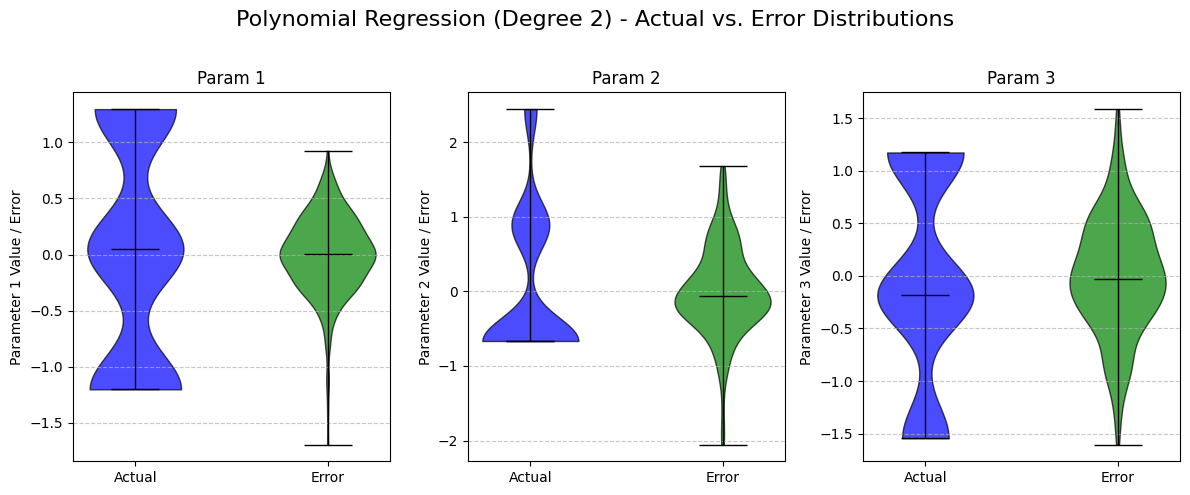

Degree 2: Overall Avg RMSE = 0.4977

===== Evaluating Feature Subset: pphase =====
Using X_subset with shape: (344, 8)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 45)


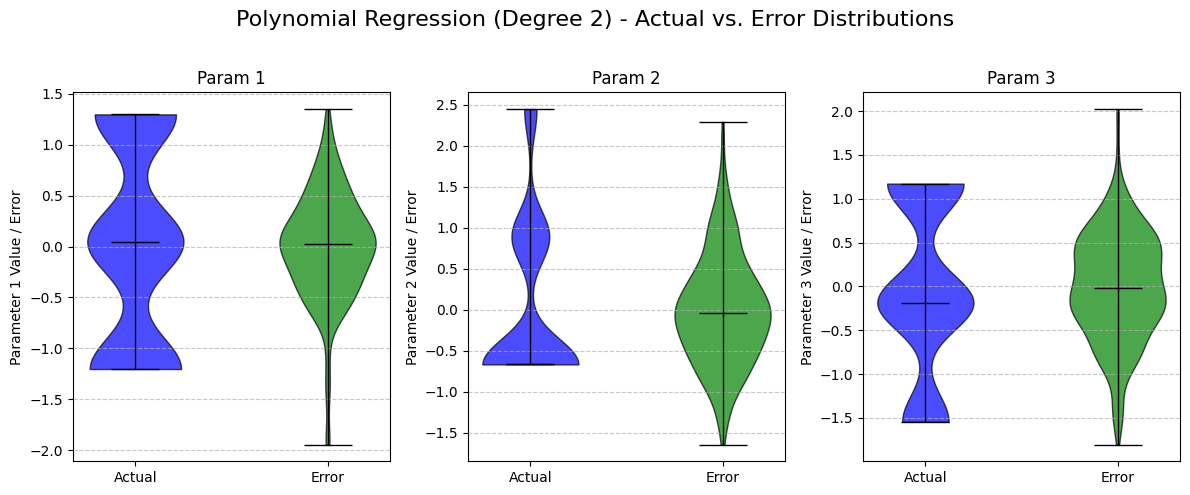

Degree 2: Overall Avg RMSE = 0.6052

===== Evaluating Feature Subset: ophase =====
Using X_subset with shape: (344, 4)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 15)


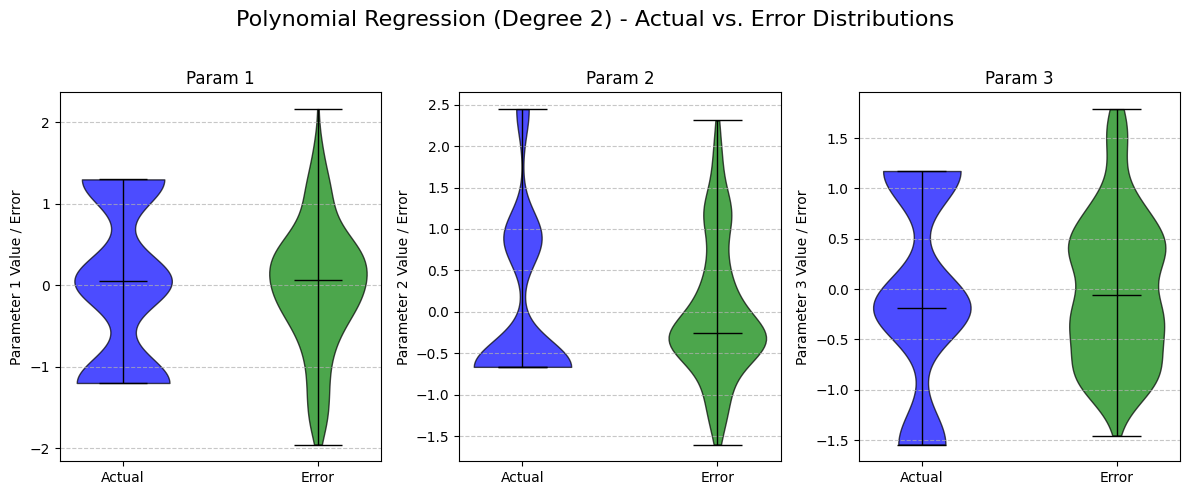

Degree 2: Overall Avg RMSE = 0.7639

===== Evaluating Feature Subset: pvalue+pphase =====
Using X_subset with shape: (344, 16)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 153)


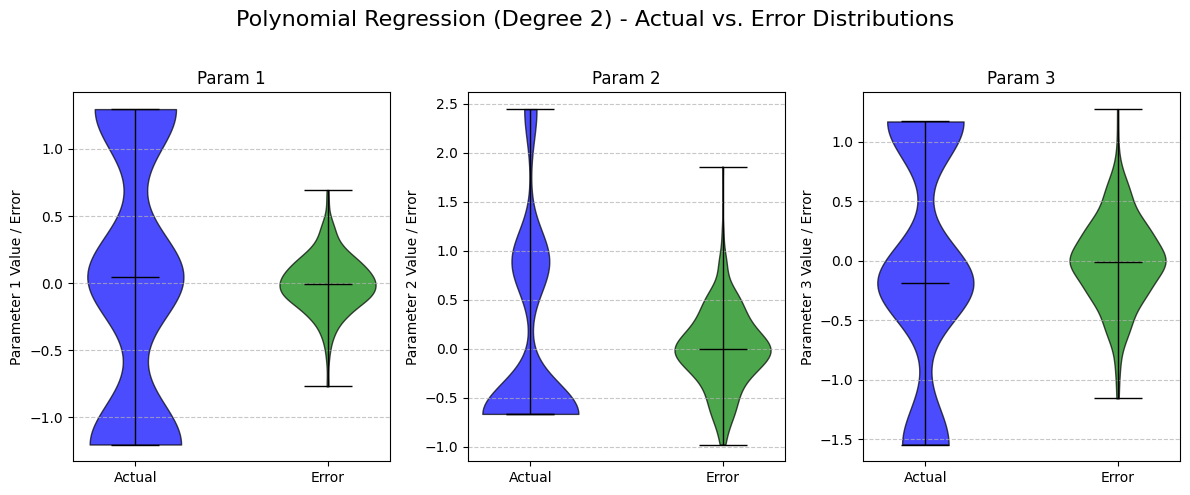

Degree 2: Overall Avg RMSE = 0.3243

===== Evaluating Feature Subset: pvalue+ophase =====
Using X_subset with shape: (344, 12)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 91)


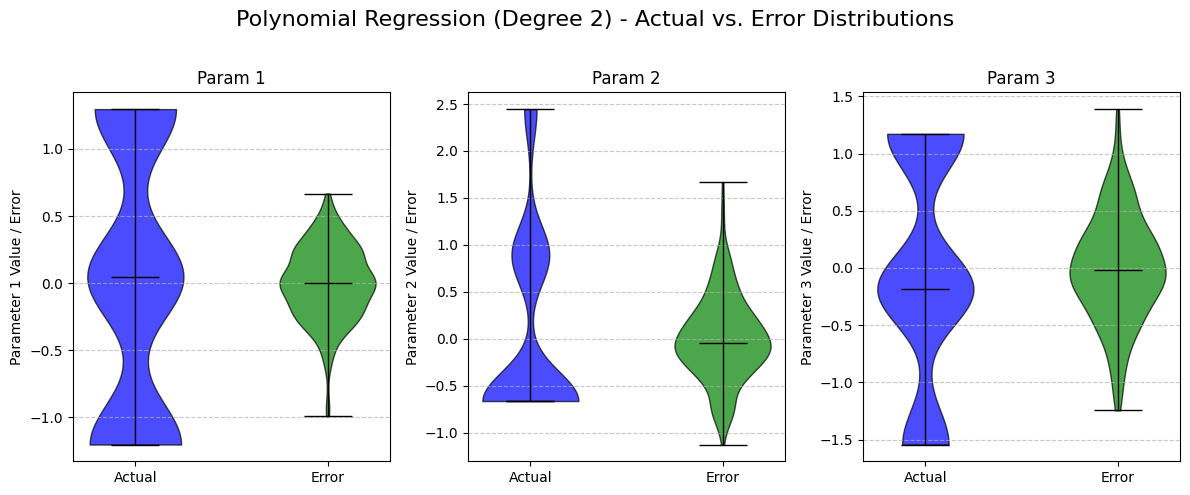

Degree 2: Overall Avg RMSE = 0.3969

===== Evaluating Feature Subset: pphase+ophase =====
Using X_subset with shape: (344, 12)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 91)


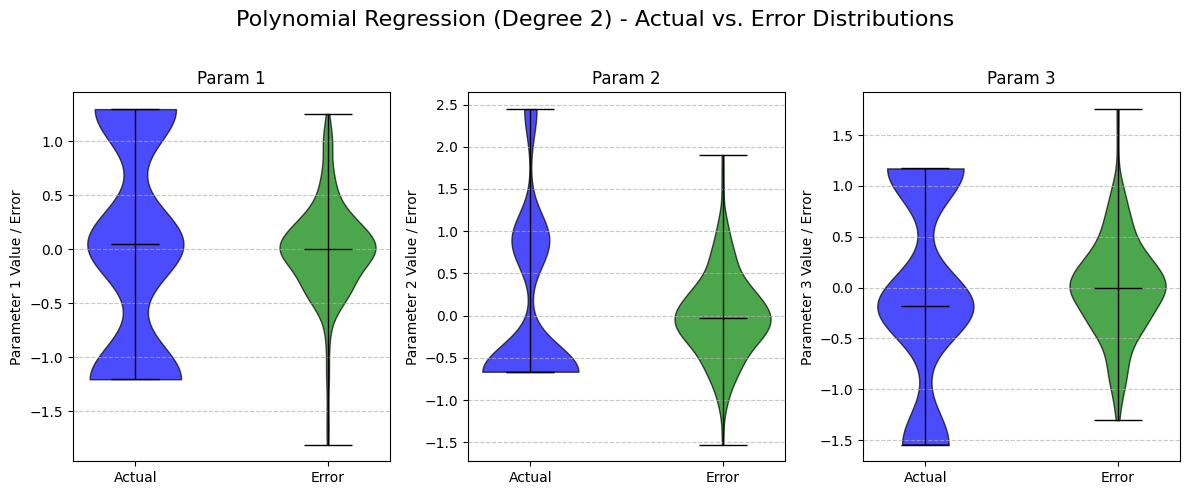

Degree 2: Overall Avg RMSE = 0.4719

===== Evaluating Feature Subset: pvalue+pphase+ophase =====
Using X_subset with shape: (344, 20)
Degree 2 - Weight matrix shape (coefficients of polynomial features): (3, 231)


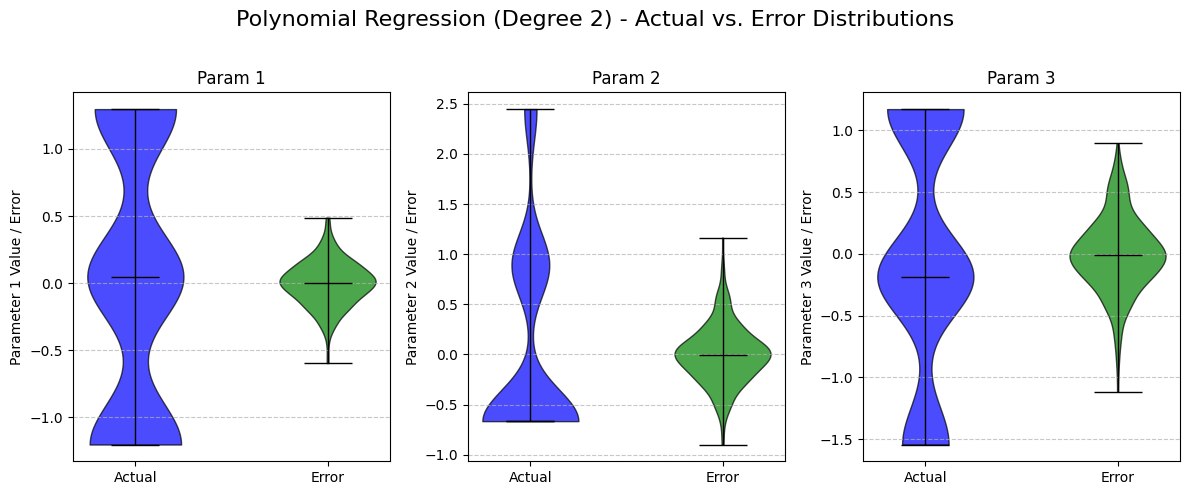

Degree 2: Overall Avg RMSE = 0.2553


In [5]:

# Degrees for polynomial regression (as in the original placeholder)
degrees_to_test_for_subsets = [2]

# Run the analysis for the defined feature subsets
if feature_subsets:
    analyze_feature_subsets_rmse(X, y, feature_subsets, degrees_to_test_for_subsets, make_plots=True)
else:
    print("No feature subsets were defined to analyze. Skipping analysis.")



In [6]:
# the coefficient fit might overfit the data, so we can use a regularization method
from sklearn.linear_model import Ridge
# Ridge regression
ridge = Ridge(alpha=1.0)  # You can adjust the alpha parameter for regularization strength
ridge.fit(X, y)
y_pred_ridge = ridge.predict(X)
W_ridge = ridge.coef_

In [7]:
# Get feature names for polynomial features
feature_names = polyreg.named_steps['polynomialfeatures'].get_feature_names_out()

# Get absolute values of coefficients for each target parameter
coef_abs = np.abs(polyreg.named_steps[name].coef_)

# For each target parameter, print the top 5 most relevant features
for target_idx in range(coef_abs.shape[0]):
    print(f"\nTop 5 relevant features for parameter {target_idx + 1}:")
    top_idx = np.argsort(coef_abs[target_idx])[::-1][:5]
    for idx in top_idx:
        print(f"  {feature_names[idx]}: {coef_abs[target_idx, idx]:.4f}")



NameError: name 'polyreg' is not defined

In [ ]:
ss = np.concatenate(states, axis=0)
# add params to state
cf = np.concatenate([ np.ones((len(states[i]),1 )) * params[i] for i in range(params.shape[0])])
ss = np.concatenate([ss,cf] , axis=1)
# normalize each feature
ss = (ss - ss.mean(axis = 0)) / ss.std(axis = 0)
ss.shape

(383, 23)

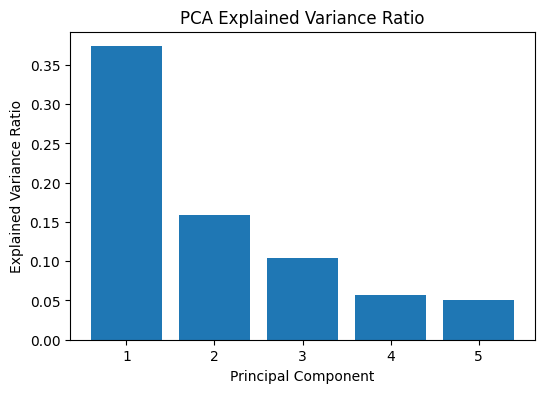

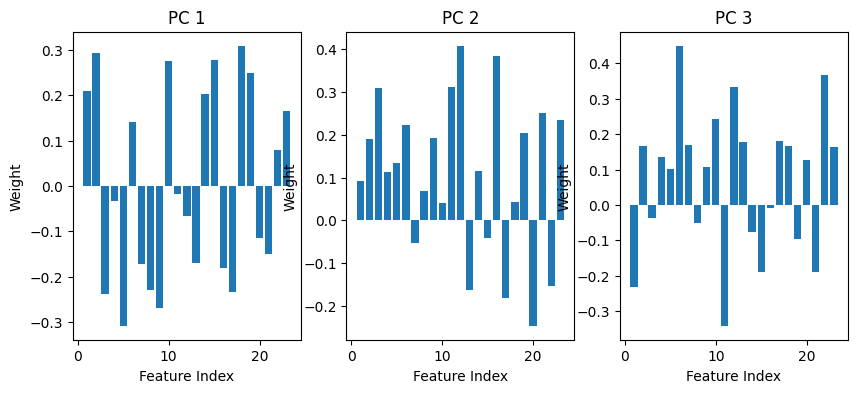

In [ ]:
# PCA: find the main components of the state space
from sklearn.decomposition import PCA

# PCA is used to reduce the dimensionality of the state space
# for instance, if we have 10 features, we can reduce it to 2 or 3
# state mean row is the 

pca = PCA(n_components=5)
pca.fit(ss)
pca_ss = pca.transform(ss)
# check the variance explained by each component, visualize the results
pca.explained_variance_ratio_
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('PCA Explained Variance Ratio')
plt.show()

# visualize the weights of the first 3 components, each component is a linear combination of the original features
plt.figure(figsize=(10, 4))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f'PC {i + 1}')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.bar(range(1, len(pca.components_[i]) + 1), pca.components_[i])




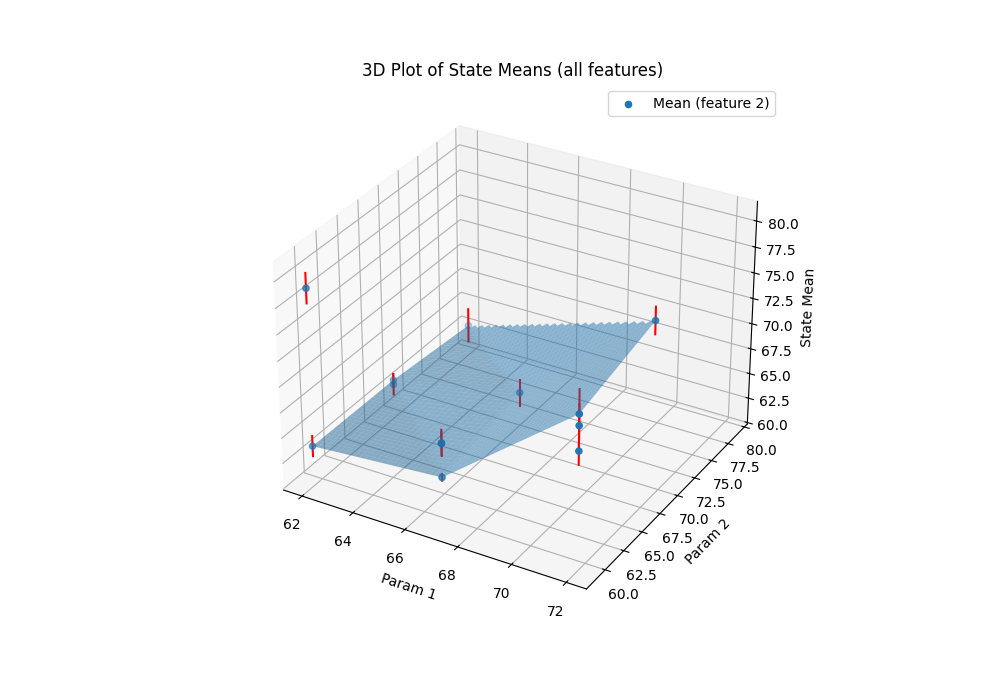

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = params[:, 0]
y = params[:, 1]

names = ["max actuator position", 
         "min actuator position", 
         "max actuator velocity",
         "min actuator velocity",
         "max hip velocity",
         "min hip velocity",
         "max actuator position phase", 
         "min actuator position phase", 
         "ST SW transition phase", 
         "brake time", 
         "toe off time",
         "max loadcell force"]
for i in [2]: #range(state_mean.shape[1]):
    feature = i
    ax.scatter(x, y, state_mean[:, feature], label=f"Mean (feature {feature})")
    # draw +- std as a interpolated line at each point
    for i in range(len(x)):
        ax.plot([x[i], x[i]], [y[i], y[i]], [state_mean[i, feature] - state_std[i, feature], state_mean[i, feature] + state_std[i, feature]], color='r')
        # ax.plot([x[i], x[i]], [y[i], y[i]], [state_mean[i, feature], state_mean[i, feature]], color='b')
    
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    xi, yi = np.meshgrid(xi, yi)
    zi = griddata((x, y), state_mean[:, feature], (xi, yi), method='linear')
    # zi_std = griddata((x, y), state_std[:, feature], (xi, yi), method='linear')
    ax.plot_surface(xi, yi, zi, alpha=0.5)
    # ax.plot_surface(xi, yi, zi + zi_std, alpha=0.5, color='r')
    # ax.plot_surface(xi, yi, zi - zi_std, alpha=0.5, color='r')

    # ax.scatter(x, y, state_std[:, feature], label=f"Std (feature {feature})", color='r')
    # Create a grid for interpolation
    

    
ax.set_xlabel('Param 1')
ax.set_ylabel('Param 2')
ax.set_zlabel('State Mean')
ax.set_title('3D Plot of State Means (all features)')
ax.legend()
plt.show()